## NN Classifier over LDA Features
In this notebook, we train a neural network over LDA features. We use the
Keras wrapper for Theano, which is a deep learning library. We also use cuDNN library to train the neural networks over a 640 core GPU.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 750 Ti (0000:01:00.0)


In [2]:
topics_filename = 'lda_data300b_all.csv'
train_filename = 'train.csv'
data_ncol = 600

In [3]:
df = pd.read_csv(topics_filename, header=None)
df = df.drop(data_ncol,1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.250801,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(404290, 600)

In [5]:
df_text = pd.read_csv(train_filename).fillna("")
df_text.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
print df_text.shape
print df.shape

(404290, 6)
(404290, 600)


In [7]:
X = df.values
y = df_text.iloc[:,-1:].values.ravel()
del df_text

In [8]:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed) 

In [9]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint 

#### Build, Train and Verify
We build a neural network model and train it over a predecided portion of the dataset while simultaneously verifying it over another predecided test dataset. We also save the weights corresponding to the best accuracy achieved over the the test set, during the learning process. Later, we use these weights to evaluate the performance of the best trained network.

In [10]:
#create model
model = Sequential()
model.add(Dense(600, input_dim=600, kernel_initializer='uniform', activation='relu'))
model.add(Dense(600, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint 
filepath='weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc' , verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, callbacks=callbacks_list, batch_size=10000)

Train on 270874 samples, validate on 133416 samples
Epoch 1/20
270874/270874 [==============================] - 2s - loss: 0.6523 - acc: 0.6300 - val_loss: 0.6319 - val_acc: 0.6312
Epoch 2/20
270874/270874 [==============================] - 2s - loss: 0.6253 - acc: 0.6482 - val_loss: 0.6195 - val_acc: 0.6639
Epoch 3/20
270874/270874 [==============================] - 2s - loss: 0.6104 - acc: 0.6740 - val_loss: 0.5975 - val_acc: 0.6823
Epoch 4/20
270874/270874 [==============================] - 2s - loss: 0.5782 - acc: 0.6936 - val_loss: 0.5739 - val_acc: 0.6930
Epoch 5/20
270874/270874 [==============================] - 2s - loss: 0.5481 - acc: 0.7116 - val_loss: 0.5514 - val_acc: 0.7072
Epoch 6/20
270874/270874 [==============================] - 2s - loss: 0.5218 - acc: 0.7291 - val_loss: 0.5459 - val_acc: 0.7154
Epoch 7/20
270874/270874 [==============================] - 2s - loss: 0.4978 - acc: 0.7464 - val_loss: 0.5305 - val_acc: 0.7242
Epoch 8/20
270874/270874 [===================

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Plotting Accuracy History
We plot the history of accuracy during the training of the neural network for both the training and test set. We observe that while the accuracy continues to grow for the training set, it saturates for the test set. This can be interpreted as overfitting the training portion.

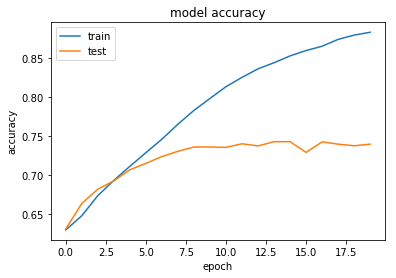

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Performance Evaluation

In [13]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

##### ROC Curve over Test Set

133088/133416 [============================>.] - ETA: 0s

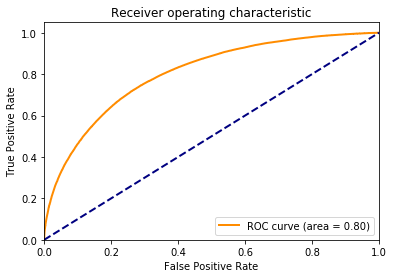

In [15]:
# load weights
model.load_weights("weights.best.hdf5")
y_pred_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##### ROC Curve over Training Set

270560/270874 [============================>.] - ETA: 0s

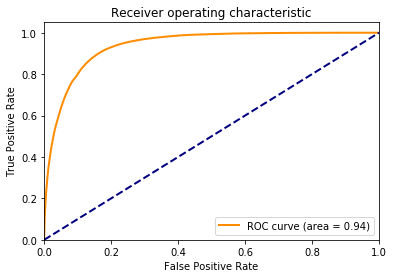

In [16]:
# load weights
model.load_weights("weights.best.hdf5")
y_pred_prob_tr = model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_tr)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
print y_test.shape
print y_pred_prob.shape

(133416L,)
(133416L, 1L)


##### Precision Recall Curve over Test Set

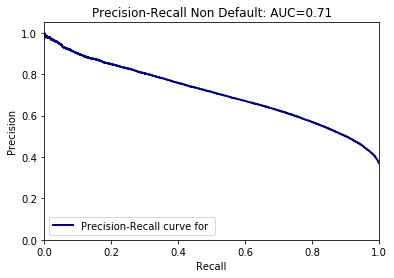

In [18]:
precision = dict()
recall = dict()
average_precision = dict()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve for ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Non Default: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

##### Confusion Matrix

In [19]:
y_pred = model.predict_classes(X_test).ravel()

133312/133416 [============================>.] - ETA: 0s

In [20]:
print confusion_matrix(y_test, y_pred)

[[72578 11628]
 [22620 26590]]


#### Find Average Accuracy with 10-Fold Crossvalidation
Here, we use the StratifiedKFold class from the scikit-learn to split up the training dataset into 10 folds. The folds are stratiﬁed, meaning that the algorithm attempts to balance the number of instances of each class in each fold. The example creates and evaluates 10 models using the 10 splits of the data and collects all of the scores. The verbose output for each epoch is turned off by passing verbose=0 to the fit() and evaluate() functions on the model. The performance is printed for each model and it is stored. The average and standard deviation of the model performance is then printed at the end of the run to provide a robust estimate of model accuracy.


In [21]:
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(600, input_dim=600, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(600, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], y[train], epochs=10, batch_size=10000, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 74.24%
acc: 74.03%
acc: 74.11%
acc: 74.39%
acc: 74.38%
acc: 74.76%
acc: 74.61%
acc: 74.66%
acc: 74.74%
acc: 74.91%
74.48% (+/- 0.28%)


### Employing Dropout
We experiment with dropout by inserting dropout in the input and deep layers. 
We see that we get some improvement in the ROC area under the curve by using the drop out, which means slightly better prediction performance and less overfitting.

In [22]:
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dropout

In [23]:
#create model
model = Sequential()
model.add(Dropout(0.2, input_shape=(600,)))
model.add(Dense(600, input_dim=600, kernel_initializer='uniform', 
                activation='relu',  kernel_constraint=maxnorm(2.)))
model.add(Dropout(0.2))
model.add(Dense(600, kernel_initializer='uniform', activation='relu',
                kernel_constraint=maxnorm(2.)))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
#sgd = SGD(lr=1.0, momentum=0.9, decay=0.001, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
# checkpoint 
filepath='weights_do.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc' , verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test), batch_size=10000, callbacks=callbacks_list)

Train on 270874 samples, validate on 133416 samples
Epoch 1/20
270874/270874 [==============================] - 2s - loss: 0.6554 - acc: 0.6289 - val_loss: 0.6340 - val_acc: 0.6312
Epoch 2/20
270874/270874 [==============================] - 2s - loss: 0.6314 - acc: 0.6390 - val_loss: 0.6211 - val_acc: 0.6626
Epoch 3/20
270874/270874 [==============================] - 2s - loss: 0.6206 - acc: 0.6633 - val_loss: 0.6064 - val_acc: 0.6701
Epoch 4/20
270874/270874 [==============================] - 2s - loss: 0.6003 - acc: 0.6782 - val_loss: 0.5831 - val_acc: 0.6863
Epoch 5/20
270874/270874 [==============================] - 2s - loss: 0.5833 - acc: 0.6869 - val_loss: 0.5703 - val_acc: 0.6935
Epoch 6/20
270874/270874 [==============================] - 2s - loss: 0.5722 - acc: 0.6928 - val_loss: 0.5619 - val_acc: 0.7012
Epoch 7/20
270874/270874 [==============================] - 2s - loss: 0.5628 - acc: 0.7001 - val_loss: 0.5511 - val_acc: 0.7083
Epoch 8/20
270874/270874 [===================

##### Accuracy of History during Training

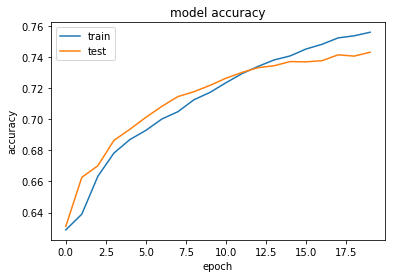

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### ROC Curve for Test Set

133152/133416 [============================>.] - ETA: 0s

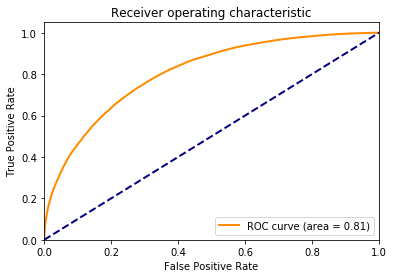

In [25]:
# load weights
model.load_weights("weights_do.best.hdf5")
y_pred_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

For the LDA features, we find a 1% improvement in the area under ROC by employing dropout.

##### ROC Curve for Training Set

270624/270874 [============================>.] - ETA: 0s  

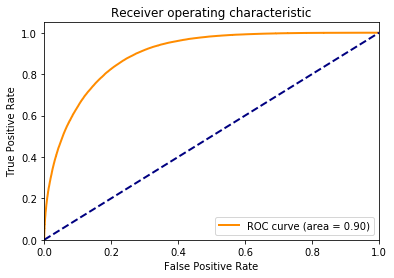

In [26]:
y_pred_prob = model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We do see a decrease in the area under the ROC of 0.04, which means that the model complexity has been reduced as compared to without dropout.

##### Precision Recall Curve over Test Set

In [27]:
model = Sequential()
model.add(Dropout(0.2, input_shape=(600,)))
model.add(Dense(600, input_dim=600, kernel_initializer='uniform', 
                activation='relu',  kernel_constraint=maxnorm(2.)))
model.add(Dropout(0.2))
model.add(Dense(600, kernel_initializer='uniform', activation='relu',
                kernel_constraint=maxnorm(2.)))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
#model.load_weights("weights_do.best.hdf5")
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [28]:
model.load_weights("weights_do.best.hdf5")
y_pred_prob = model.predict_proba(X_test)

133280/133416 [============================>.] - ETA: 0s

##### Precision Recall Curve over Test Set

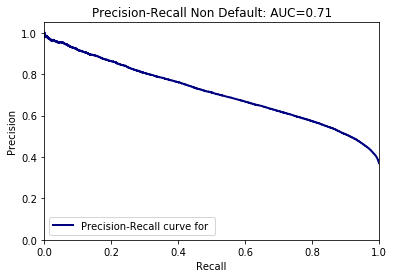

In [29]:
precision = dict()
recall = dict()
average_precision = dict()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve for ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Non Default: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

In [30]:
y_pred = model.predict_classes(X_test).ravel()

132672/133416 [============================>.] - ETA: 0s

##### Confusion Matrix

In [31]:
print confusion_matrix(y_test, y_pred)

[[71762 12444]
 [21848 27362]]


We see that the recall of the duplicate class has improved a little bit, while there is drop in the recall of the non-duplicate class.